## Part 1: Monte Carlo Tree Search (MCTS)

----

Running MCTS experiments...

Running experiments for c=0.5


100%|██████████| 50/50 [00:00<00:00, 16559.95it/s]



Running experiments for c=1.4


100%|██████████| 50/50 [00:00<00:00, 16678.48it/s]



Running experiments for c=2.0


100%|██████████| 50/50 [00:00<00:00, 16573.04it/s]



Running experiments for c=3.0


100%|██████████| 50/50 [00:00<00:00, 16662.58it/s]



Running experiments for c=5.0


100%|██████████| 50/50 [00:00<00:00, 16533.84it/s]


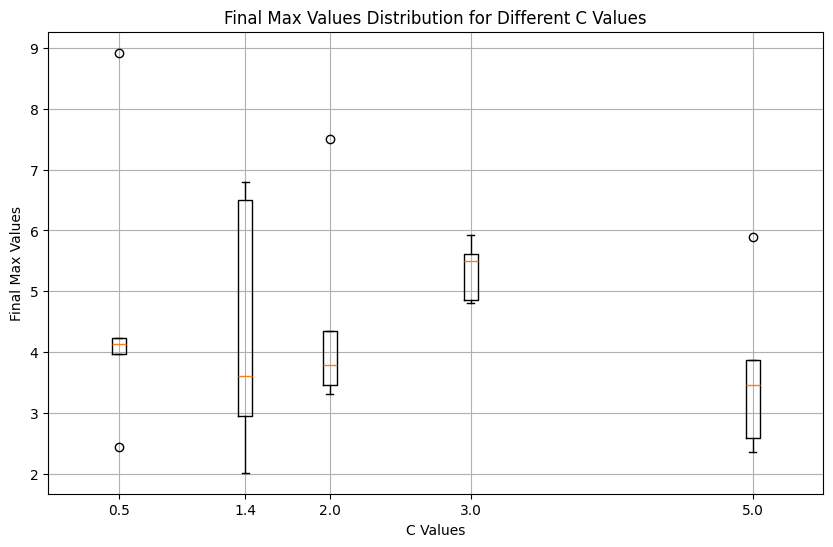

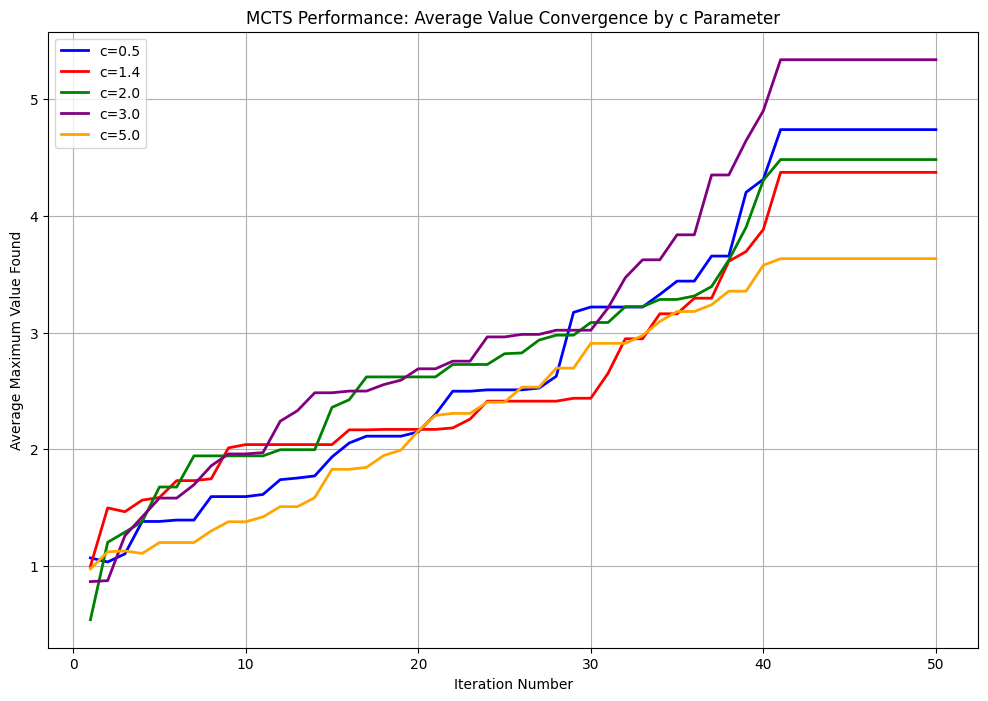


Analysis of MCTS Performance:
--------------------------------------------------

For c = 0.5:
Average final value: 4.74
Standard deviation: 2.19
Best value found: 8.92

For c = 1.4:
Average final value: 4.37
Standard deviation: 1.93
Best value found: 6.80

For c = 2.0:
Average final value: 4.48
Standard deviation: 1.55
Best value found: 7.50

For c = 3.0:
Average final value: 5.34
Standard deviation: 0.44
Best value found: 5.92

For c = 5.0:
Average final value: 3.63
Standard deviation: 1.26
Best value found: 5.89

Analysis of MCTS Performance:
--------------------------------------------------

For c = 0.5:
Average final value: 4.74
Standard deviation: 2.19
Best value found: 8.92

For c = 1.4:
Average final value: 4.37
Standard deviation: 1.93
Best value found: 6.80

For c = 2.0:
Average final value: 4.48
Standard deviation: 1.55
Best value found: 7.50

For c = 3.0:
Average final value: 5.34
Standard deviation: 0.44
Best value found: 5.92

For c = 5.0:
Average final value: 3.63
Stan

In [1]:

import numpy as np
from collections import defaultdict
import random
import math
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

class Node:
    def __init__(self, address=""):
        self.address = address
        self.visits = 0
        self.value = 0
        self.children = {}

class MCTSTree:
    def __init__(self, depth=20, B=10, tau=4, target_address=None):
        self.depth = depth
        self.B = B
        self.tau = tau
        self.target_address = target_address or ''.join(random.choice(['L', 'R']) for _ in range(depth))
        self.values_cache = {}

    def edit_distance(self, addr1, addr2):
        """Count positions where strings differ"""
        return sum(a != b for a, b in zip(addr1.ljust(len(addr2)), addr2.ljust(len(addr1))))

    def get_leaf_value(self, address):
        """Get or compute leaf node value"""
        if address in self.values_cache:
            return self.values_cache[address]

        dist = self.edit_distance(address, self.target_address)
        value = self.B * math.exp(-dist/self.tau) + np.random.normal(0, 1)
        self.values_cache[address] = value
        return value

    def ucb_score(self, parent_visits, node_visits, node_value, c):
        """Calculate UCB score"""
        if node_visits == 0:
            return float('inf')
        return node_value/node_visits + c * math.sqrt(math.log(parent_visits)/node_visits)

    def select(self, node, c):
        """Select next node to explore"""
        if len(node.children) == 0 or len(node.address) == self.depth:
            return node

        ucb_scores = {
            action: self.ucb_score(node.visits, 
                                 child.visits,
                                 child.value,
                                 c)
            for action, child in node.children.items()
        }
        best_action = max(ucb_scores.items(), key=lambda x: x[1])[0]
        return self.select(node.children[best_action], c)

    def expand(self, node):
        """Expand node by adding all possible children"""
        if len(node.address) < self.depth:
            for action in ['L', 'R']:
                if action not in node.children:
                    new_address = node.address + action
                    node.children[action] = Node(new_address)
        return node

    def simulate(self, node):
        """Simulate random playout"""
        current_address = node.address
        while len(current_address) < self.depth:
            current_address += random.choice(['L', 'R'])
        return self.get_leaf_value(current_address)

    def backpropagate(self, node, value):
        """Update node statistics"""
        node.visits += 1
        node.value += value

    def collect_stats(self, node):
        """Collect statistics about the current tree state"""
        stats = {
            'total_visits': 0,
            'max_value': float('-inf'),
            'max_depth': 0,
            'depth_distribution': defaultdict(int)
        }

        def traverse(n, depth=0):
            stats['total_visits'] += n.visits
            if n.visits > 0:
                value = n.value / n.visits
                stats['max_value'] = max(stats['max_value'], value)
            stats['max_depth'] = max(stats['max_depth'], depth)
            stats['depth_distribution'][depth] += n.visits

            for child in n.children.values():
                traverse(child, depth + 1)

        traverse(node)
        return stats

    def search(self, num_iterations=50, c=1.4, num_rollouts=5):
        """Perform MCTS search with limited rollouts"""
        root = Node()
        iterations_data = []

        for i in tqdm(range(num_iterations)):
            # Selection
            leaf = self.select(root, c)

            # Expansion
            if leaf.visits > 0:
                leaf = self.expand(leaf)
                if leaf.children:
                    leaf = random.choice(list(leaf.children.values()))

            # Multiple rollouts
            value = 0
            for _ in range(num_rollouts):
                value += self.simulate(leaf)
            value /= num_rollouts  # Average the rollouts

            # Backpropagation
            current = leaf
            while current:
                self.backpropagate(current, value)
                current = None if not current.address else root
                for char in current.address[:-1] if current else []:
                    current = current.children[char]

            # Collect iteration statistics
            iteration_stats = self.collect_stats(root)
            iterations_data.append(iteration_stats)

        return root, iterations_data

def run_experiments(depth=20, iterations=50, c_values=[0.5, 1.4, 2.0, 3.0, 5.0], runs=5):
    """Run experiments for different c values"""
    results = []

    for c in c_values:
        print(f"\nRunning experiments for c={c}")
        final_max_values = []
        all_iterations_data = []

        for run in range(runs):
            tree = MCTSTree(depth=depth)
            root, iterations_data = tree.search(num_iterations=iterations, c=c, num_rollouts=5)
            final_max_value = max(data['max_value'] for data in iterations_data)
            final_max_values.append(final_max_value)
            all_iterations_data.append(iterations_data)

        results.append({
            'c': c,
            'final_max_values': final_max_values,
            'iterations_data': all_iterations_data
        })

    return results

def analyze_results(results):
    """Statistical analysis of results"""
    grouped_data = [res['final_max_values'] for res in results]

    print("\nPerforming ANOVA...")
    anova_result = f_oneway(*grouped_data)
    print("ANOVA Result:", anova_result)

    if anova_result.pvalue < 0.05:
        print("\nPerforming post hoc analysis...")
        data = []
        labels = []
        for res in results:
            data.extend(res['final_max_values'])
            labels.extend([res['c']] * len(res['final_max_values']))

        tukey = pairwise_tukeyhsd(data, labels)
        print("\nTukey's HSD Results:")
        print(tukey)

def plot_results(results):
    """Create an improved visualization of the results"""
    plt.figure(figsize=(12, 8))
    colors = ['blue', 'red', 'green', 'purple', 'orange']

    # Plot average lines for each c value
    for idx, res in enumerate(results):
        c = res['c']
        # Calculate average across runs
        avg_values = []
        for i in range(len(res['iterations_data'][0])):
            values = [run_data[i]['max_value'] for run_data in res['iterations_data']]
            avg_values.append(np.mean(values))

        iterations = range(1, len(avg_values) + 1)
        plt.plot(iterations, avg_values, label=f'c={c}', 
                color=colors[idx], linewidth=2)

    plt.xlabel('Iteration Number')
    plt.ylabel('Average Maximum Value Found')
    plt.title('MCTS Performance: Average Value Convergence by c Parameter')
    plt.legend()
    plt.grid(True)
    plt.show()


def analyze_results(results):
    """Provide a clearer analysis of the results"""
    print("\nAnalysis of MCTS Performance:")
    print("-" * 50)

    for res in results:
        c = res['c']
        final_values = res['final_max_values']

        print(f"\nFor c = {c}:")
        print(f"Average final value: {np.mean(final_values):.2f}")
        print(f"Standard deviation: {np.std(final_values):.2f}")
        print(f"Best value found: {np.max(final_values):.2f}")

def box_plot_results(results):
    """Create box plot of results"""
    plt.figure(figsize=(10, 6))
    for res in results:
        c = res['c']
        max_values = res['final_max_values']
        plt.boxplot(max_values, positions=[c], widths=0.1)

    plt.xlabel('C Values')
    plt.ylabel('Final Max Values')
    plt.title('Final Max Values Distribution for Different C Values')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    print("Running MCTS experiments...")

    # Run experiments with parameters matching assignment requirements
    results = run_experiments(
        depth=20,          # Tree depth as specified
        iterations=50,     # Limited iterations
        c_values=[0.5, 1.4, 2.0, 3.0, 5.0],
        runs=5
    )

    # Analyze and visualize results
    box_plot_results(results)
    plot_results(results)
    analyze_results(results)
    analyze_results(results)

Running comprehensive MCTS analysis...

Running experiments for c=0.5
Run 1/10


100%|██████████| 50/50 [00:00<00:00, 9027.77it/s]


Run 2/10


100%|██████████| 50/50 [00:00<00:00, 11953.67it/s]


Run 3/10


100%|██████████| 50/50 [00:00<00:00, 9011.48it/s]


Run 4/10


100%|██████████| 50/50 [00:00<00:00, 16653.32it/s]


Run 5/10


100%|██████████| 50/50 [00:00<00:00, 12504.63it/s]


Run 6/10


100%|██████████| 50/50 [00:00<00:00, 10005.97it/s]


Run 7/10


100%|██████████| 50/50 [00:00<00:00, 16686.44it/s]


Run 8/10


100%|██████████| 50/50 [00:00<00:00, 12501.65it/s]


Run 9/10


100%|██████████| 50/50 [00:00<00:00, 13806.14it/s]


Run 10/10


100%|██████████| 50/50 [00:00<00:00, 14624.49it/s]



Running experiments for c=1.4
Run 1/10


100%|██████████| 50/50 [00:00<00:00, 12415.06it/s]


Run 2/10


100%|██████████| 50/50 [00:00<00:00, 16567.80it/s]


Run 3/10


100%|██████████| 50/50 [00:00<00:00, 9518.66it/s]


Run 4/10


100%|██████████| 50/50 [00:00<00:00, 12382.07it/s]


Run 5/10


100%|██████████| 50/50 [00:00<00:00, 9020.78it/s]


Run 6/10


100%|██████████| 50/50 [00:00<00:00, 11074.95it/s]


Run 7/10


100%|██████████| 50/50 [00:00<00:00, 12504.63it/s]


Run 8/10


100%|██████████| 50/50 [00:00<00:00, 16030.82it/s]


Run 9/10


100%|██████████| 50/50 [00:00<00:00, 12503.14it/s]


Run 10/10


100%|██████████| 50/50 [00:00<00:00, 12497.93it/s]



Running experiments for c=2.0
Run 1/10


100%|██████████| 50/50 [00:00<00:00, 14237.28it/s]


Run 2/10


100%|██████████| 50/50 [00:00<00:00, 12500.16it/s]


Run 3/10


100%|██████████| 50/50 [00:00<00:00, 16658.61it/s]


Run 4/10


100%|██████████| 50/50 [00:00<00:00, 16654.64it/s]


Run 5/10


100%|██████████| 50/50 [00:00<00:00, 12497.18it/s]


Run 6/10


100%|██████████| 50/50 [00:00<00:00, 16674.50it/s]


Run 7/10


100%|██████████| 50/50 [00:00<00:00, 16667.87it/s]


Run 8/10


100%|██████████| 50/50 [00:00<00:00, 16514.31it/s]


Run 9/10


100%|██████████| 50/50 [00:00<00:00, 16666.55it/s]


Run 10/10


100%|██████████| 50/50 [00:00<00:00, 12506.12it/s]



Running experiments for c=3.0
Run 1/10


100%|██████████| 50/50 [00:00<00:00, 12506.12it/s]


Run 2/10


100%|██████████| 50/50 [00:00<00:00, 16642.74it/s]


Run 3/10


100%|██████████| 50/50 [00:00<00:00, 12507.62it/s]


Run 4/10


100%|██████████| 50/50 [00:00<00:00, 12502.40it/s]

Run 5/10



100%|██████████| 50/50 [00:00<00:00, 14249.86it/s]


Run 6/10


100%|██████████| 50/50 [00:00<00:00, 12494.20it/s]


Run 7/10


100%|██████████| 50/50 [00:00<00:00, 16514.31it/s]


Run 8/10


100%|██████████| 50/50 [00:00<00:00, 9988.82it/s]


Run 9/10


100%|██████████| 50/50 [00:00<00:00, 12496.44it/s]


Run 10/10


100%|██████████| 50/50 [00:00<00:00, 8333.28it/s]



Running experiments for c=5.0
Run 1/10


100%|██████████| 50/50 [00:00<00:00, 12493.46it/s]


Run 2/10


100%|██████████| 50/50 [00:00<00:00, 10002.63it/s]


Run 3/10


100%|██████████| 50/50 [00:00<00:00, 16640.10it/s]


Run 4/10


100%|██████████| 50/50 [00:00<00:00, 16657.28it/s]


Run 5/10


100%|██████████| 50/50 [00:00<00:00, 16682.46it/s]


Run 6/10


100%|██████████| 50/50 [00:00<00:00, 16698.40it/s]


Run 7/10


100%|██████████| 50/50 [00:00<00:00, 12583.42it/s]


Run 8/10


100%|██████████| 50/50 [00:00<00:00, 16675.83it/s]


Run 9/10


100%|██████████| 50/50 [00:00<00:00, 16642.74it/s]


Run 10/10


100%|██████████| 50/50 [00:00<00:00, 12507.62it/s]
C:\Users\Akkad\AppData\Local\Temp\ipykernel_48812\3936808888.py:61: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(final_values, labels=[f'c={c}' for c in c_values])



Comprehensive Analysis of MCTS Performance

c value    Avg Value    Best Value   Avg Time (s)   Std Time (s)
------------------------------------------------------------
0.5        3.48         5.21         0.01           0.00        
1.4        3.87         6.98         0.01           0.00        
2.0        3.31         6.32         0.01           0.00        
3.0        3.30         4.56         0.01           0.00        
5.0        4.01         7.16         0.01           0.00        

Generating plots...


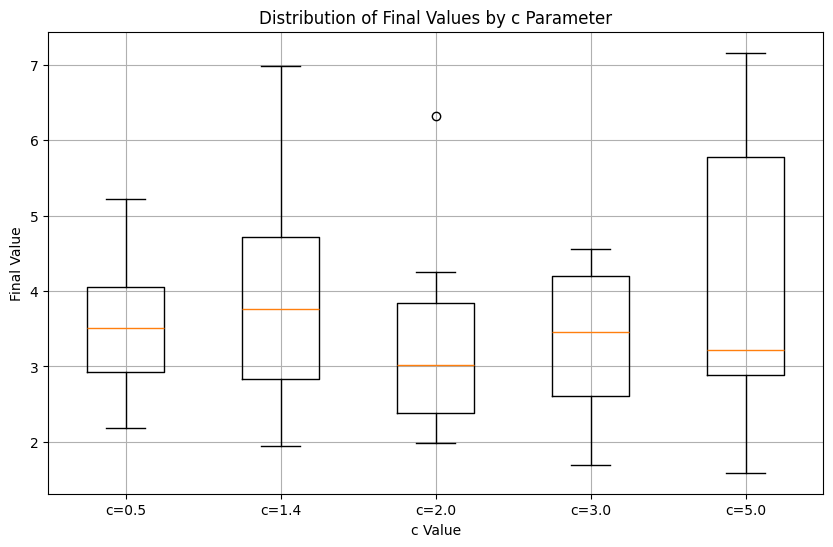

C:\Users\Akkad\AppData\Local\Temp\ipykernel_48812\3936808888.py:75: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(times, labels=[f'c={c}' for c in c_values])


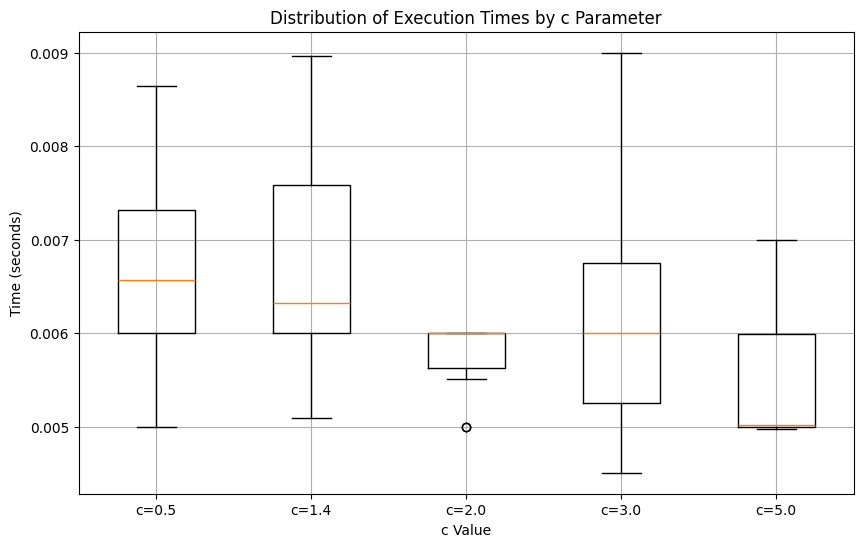

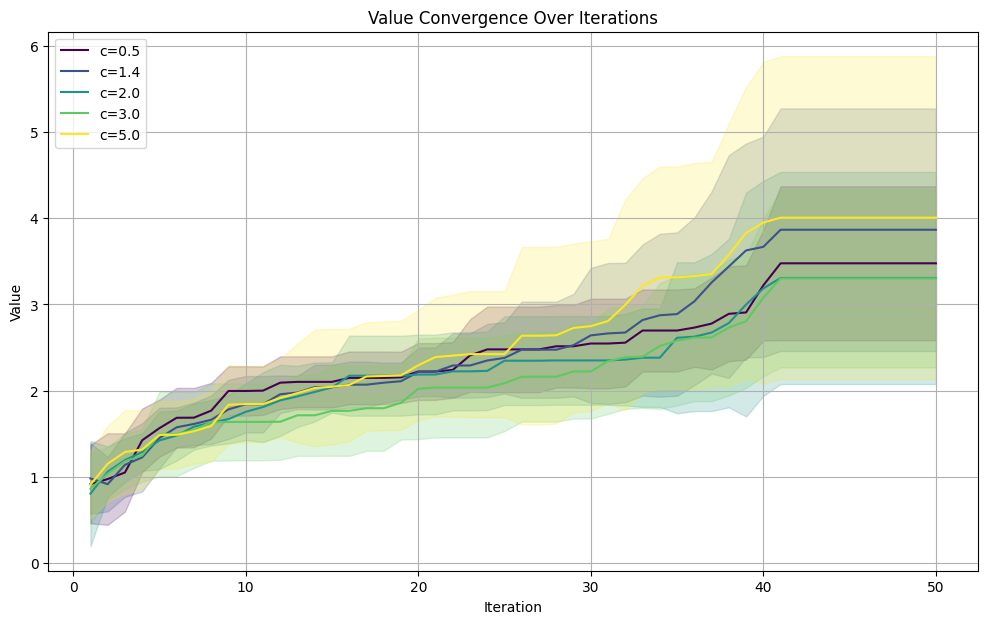


Statistical Analysis

ANOVA Test Results:
F-statistic: 0.5406
p-value: 0.7067

Tukey's HSD Test Results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 c=0.5  c=1.4   0.3891 0.9711 -1.3934 2.1716  False
 c=0.5  c=2.0  -0.1702 0.9988 -1.9527 1.6123  False
 c=0.5  c=3.0  -0.1755 0.9986 -1.9579  1.607  False
 c=0.5  c=5.0    0.529 0.9155 -1.2534 2.3115  False
 c=1.4  c=2.0  -0.5593 0.8985 -2.3418 1.2232  False
 c=1.4  c=3.0  -0.5645 0.8954  -2.347 1.2179  False
 c=1.4  c=5.0     0.14 0.9994 -1.6425 1.9224  False
 c=2.0  c=3.0  -0.0053    1.0 -1.7877 1.7772  False
 c=2.0  c=5.0   0.6992  0.798 -1.0832 2.4817  False
 c=3.0  c=5.0   0.7045 0.7936  -1.078  2.487  False
---------------------------------------------------


In [2]:
def run_experiments_with_metrics(depth=20, iterations=50, c_values=[0.5, 1.4, 2.0, 3.0, 5.0], runs=10):
    """Run experiments and collect comprehensive metrics"""
    results = []

    metrics = {c: {
        'values': [],
        'times': [],
        'final_values': []
    } for c in c_values}

    for c in c_values:
        print(f"\nRunning experiments for c={c}")

        for run in range(runs):
            print(f"Run {run + 1}/{runs}")

            # Time measurement
            start_time = time.time()

            # Run MCTS
            tree = MCTSTree(depth=depth)
            root, iterations_data = tree.search(num_iterations=iterations, c=c, num_rollouts=5)

            # Record execution time
            execution_time = time.time() - start_time

            # Record metrics
            final_value = max(data['max_value'] for data in iterations_data)
            metrics[c]['times'].append(execution_time)
            metrics[c]['final_values'].append(final_value)
            metrics[c]['values'].append([data['max_value'] for data in iterations_data])

    return metrics

def analyze_and_display_metrics(metrics):
    """Analyze and display comprehensive metrics"""
    print("\nComprehensive Analysis of MCTS Performance")
    print("=" * 50)

    # Prepare results table
    headers = ["c value", "Avg Value", "Best Value", "Avg Time (s)", "Std Time (s)"]
    print("\n{:<10} {:<12} {:<12} {:<14} {:<12}".format(*headers))
    print("-" * 60)

    for c in sorted(metrics.keys()):
        avg_value = np.mean(metrics[c]['final_values'])
        best_value = np.max(metrics[c]['final_values'])
        avg_time = np.mean(metrics[c]['times'])
        std_time = np.std(metrics[c]['times'])

        print("{:<10.1f} {:<12.2f} {:<12.2f} {:<14.2f} {:<12.2f}".format(
            c, avg_value, best_value, avg_time, std_time))

def plot_final_values_distribution(metrics):
    """Plot distribution of final values for each c value"""
    plt.figure(figsize=(10, 6))

    c_values = sorted(metrics.keys())
    final_values = [metrics[c]['final_values'] for c in c_values]

    plt.boxplot(final_values, labels=[f'c={c}' for c in c_values])
    plt.title('Distribution of Final Values by c Parameter')
    plt.ylabel('Final Value')
    plt.xlabel('c Value')
    plt.grid(True)
    plt.show()

def plot_execution_times(metrics):
    """Plot distribution of execution times for each c value"""
    plt.figure(figsize=(10, 6))

    c_values = sorted(metrics.keys())
    times = [metrics[c]['times'] for c in c_values]

    plt.boxplot(times, labels=[f'c={c}' for c in c_values])
    plt.title('Distribution of Execution Times by c Parameter')
    plt.ylabel('Time (seconds)')
    plt.xlabel('c Value')
    plt.grid(True)
    plt.show()

def plot_value_convergence(metrics):
    """Plot value convergence with standard deviation bands"""
    plt.figure(figsize=(12, 7))

    c_values = sorted(metrics.keys())
    colors = plt.cm.viridis(np.linspace(0, 1, len(c_values)))

    for c, color in zip(c_values, colors):
        values_array = np.array(metrics[c]['values'])
        mean_values = np.mean(values_array, axis=0)
        std_values = np.std(values_array, axis=0)
        iterations = range(1, len(mean_values) + 1)

        plt.plot(iterations, mean_values, label=f'c={c}', color=color)
        plt.fill_between(iterations, 
                        mean_values - std_values, 
                        mean_values + std_values, 
                        color=color, alpha=0.2)

    plt.title('Value Convergence Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

def statistical_analysis(metrics):
    """Perform statistical analysis on the results"""
    print("\nStatistical Analysis")
    print("=" * 50)

    # Prepare data for analysis
    c_values = sorted(metrics.keys())
    final_values = [metrics[c]['final_values'] for c in c_values]

    # ANOVA test
    f_stat, p_value = f_oneway(*final_values)
    print(f"\nANOVA Test Results:")
    print(f"F-statistic: {f_stat:.4f}")
    print(f"p-value: {p_value:.4f}")

    # Tukey's HSD test
    all_values = []
    labels = []
    
    for c in c_values:
        all_values.extend(metrics[c]['final_values'])
        labels.extend([f'c={c}'] * len(metrics[c]['final_values']))

    tukey = pairwise_tukeyhsd(all_values, labels)
    print("\nTukey's HSD Test Results:")
    print(tukey)

if __name__ == "__main__":
    print("Running comprehensive MCTS analysis...")

    # Run experiments with metrics
    metrics = run_experiments_with_metrics(
        depth=20,
        iterations=50,
        c_values=[0.5, 1.4, 2.0, 3.0, 5.0],
        runs=10
    )

    # Display metrics table
    analyze_and_display_metrics(metrics)

    # Show separate plots
    print("\nGenerating plots...")
    plot_final_values_distribution(metrics)
    plot_execution_times(metrics)
    plot_value_convergence(metrics)
    statistical_analysis(metrics)

----

### Part two: Reinforcement Learning: Policy Gradient and the Actor-Critic algorithm

--------

#### Shared functions:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d

np.random.seed(42)

def sigmoid(x, beta=0.5):
    """Sigmoid function for action probabilities."""
    return 1 / (1 + np.exp(-beta * x))

def get_action(state, theta, beta=0.5):
    """Determine action based on current state and policy parameter theta."""
    prob_right = sigmoid(state - theta, beta)
    return 'R' if np.random.random() < prob_right else 'L'

def simulate_episode(start_state, theta, L=20):
    """Simulate an episode given the starting state and theta."""
    state = start_state
    cumulative_reward = 0

    while -L <= state <= L:
        action = get_action(state, theta)
        if action == 'R':
            state += 1
            if state > L:  # Reached right terminal
                cumulative_reward += 20
                break
            else:
                cumulative_reward -= 1  # Non-terminal transition penalty
        else:  # action == 'L'
            state -= 1
            if state < -L:  # Reached left terminal
                cumulative_reward += 0
                break
            else:
                cumulative_reward -= 1  # Non-terminal transition penalty

    return cumulative_reward

def estimate_J(theta, L=20, n_episodes=100000):
    """Estimate J(theta) using Monte Carlo rollouts."""
    rewards = []
    start_states = np.random.randint(-L, L + 1, n_episodes)

    for start_state in start_states:
        reward = simulate_episode(start_state, theta, L)
        rewards.append(reward)

    return np.mean(rewards)

def estimate_derivative(theta, h=0.7, L=20, n_episodes=100000):
    """Estimate the derivative of J(theta) using finite differences."""
    J_theta_plus_h = estimate_J(theta + h, L, n_episodes)
    J_theta = estimate_J(theta, L, n_episodes)
    return (J_theta_plus_h - J_theta) / h


### Question 1:  

1. Estimate J(θ) by performing an appropriately large number of Monte Carlo rollouts. Do
this for a sufficiently large number of θ’s (where −L ≤ θ ≤ L), to produce a smooth-ish
looking graph. Does the result match your expectation?

Calculating J(θ): 100%|██████████| 100/100 [03:52<00:00,  2.33s/it]


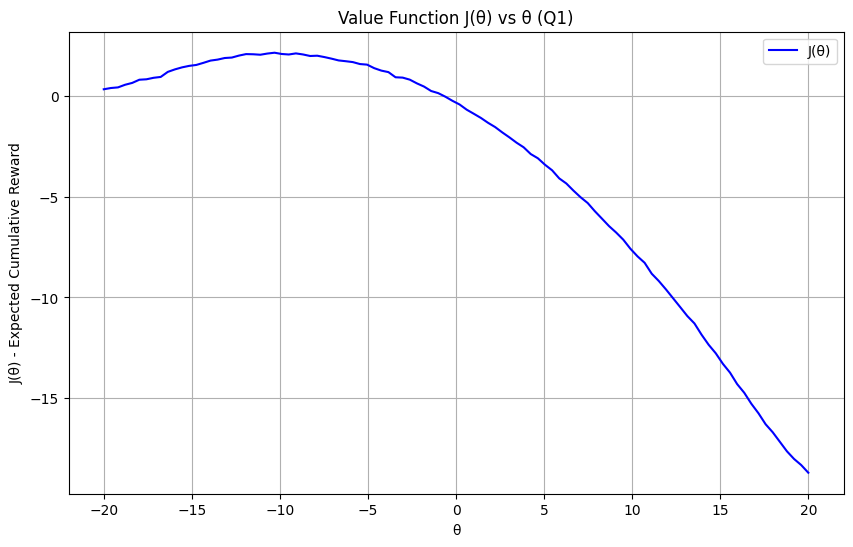

Optimal θ (Q1): -10.30
Maximum J(θ) (Q1): 2.15


In [4]:
# Generate data points for J(θ)
L = 20
theta_range = np.linspace(-L, L, 100)  # 100 evenly spaced θ values
J_values = [estimate_J(theta, L=L, n_episodes=100000) for theta in tqdm(theta_range, desc="Calculating J(θ)")]

# Plot J(θ)
plt.figure(figsize=(10, 6))
plt.plot(theta_range, J_values, 'b-', label='J(θ)')
plt.xlabel('θ')
plt.ylabel('J(θ) - Expected Cumulative Reward')
plt.title('Value Function J(θ) vs θ (Q1)')
plt.grid(True)
plt.legend()
plt.show()

optimal_theta = theta_range[np.argmax(J_values)]
print(f"Optimal θ (Q1): {optimal_theta:.2f}")
print(f"Maximum J(θ) (Q1): {max(J_values):.2f}")


### Question 2:  
Since there is only one parameter (θ), the gradient simplifies to a derivative. Estimate this
derivative numerically by using:
dJ
dθ ≈ J(θ + h) − J(θ)
h .
for small values of h. The zero-crossing of this derivative should correspond (approximately)
to the maximum of J(θ)

Calculating J values and derivatives...


Processing θ: 100%|██████████| 100/100 [11:27<00:00,  6.87s/it]


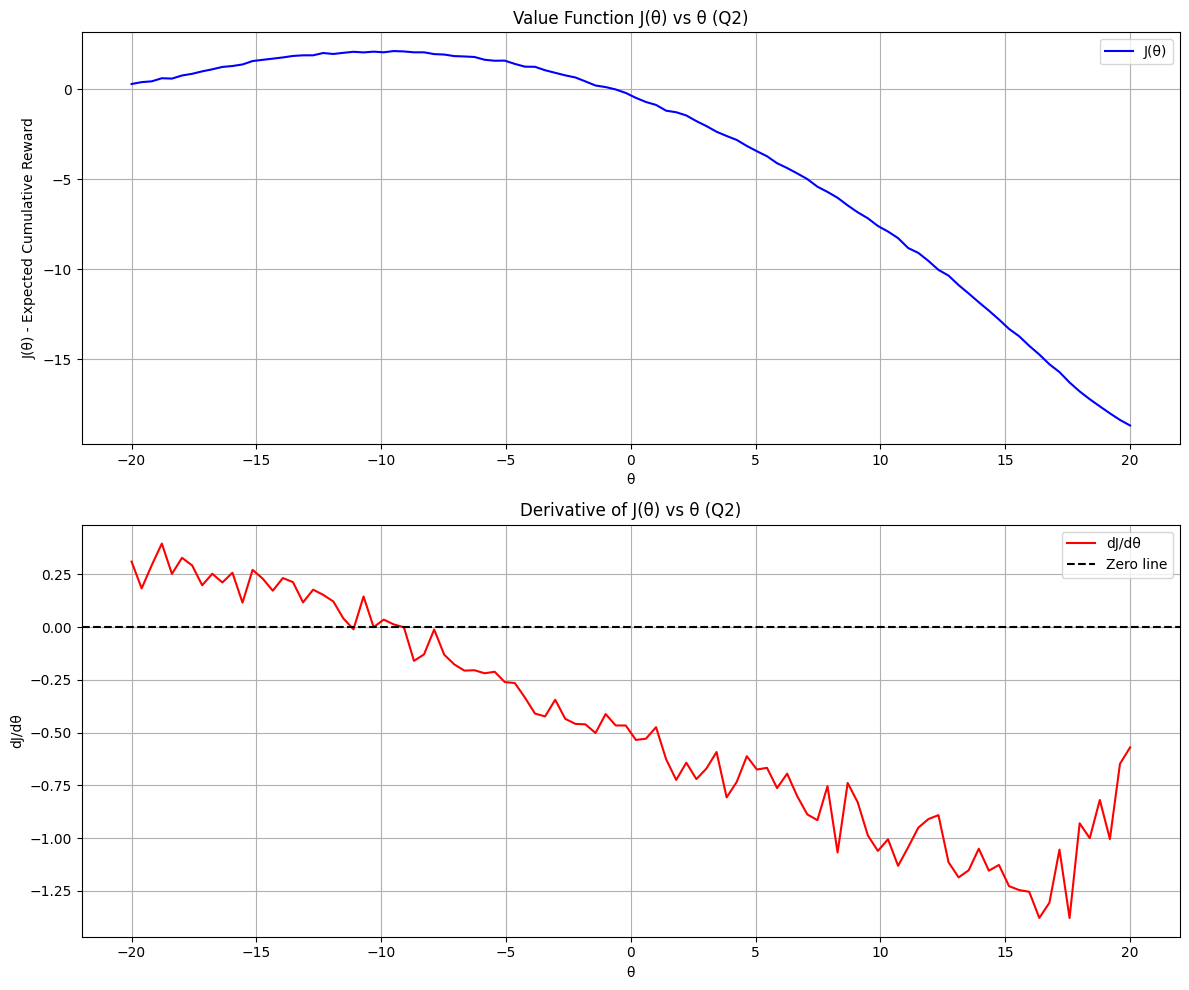

Optimal θ from J(θ) (Q2): -9.49
Maximum J(θ) (Q2): 2.12
Zero crossing of derivative (approximate optimal θ): -11.52


In [5]:
# Generate data points for J(θ) and its derivative
L= 20
theta_range = np.linspace(-L, L, 100)
J_values = []
derivatives = []

print("Calculating J values and derivatives...")
for theta in tqdm(theta_range, desc="Processing θ"):
    J_val = estimate_J(theta, L=L, n_episodes=100000)
    deriv = estimate_derivative(theta, h=0.7, L=L, n_episodes=100000)
    J_values.append(J_val)
    derivatives.append(deriv)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot J(θ)
ax1.plot(theta_range, J_values, 'b-', label='J(θ)')
ax1.set_xlabel('θ')
ax1.set_ylabel('J(θ) - Expected Cumulative Reward')
ax1.set_title('Value Function J(θ) vs θ (Q2)')
ax1.grid(True)
ax1.legend()

# Plot derivative dJ/dθ
ax2.plot(theta_range, derivatives, 'r-', label='dJ/dθ')
ax2.axhline(y=0, color='k', linestyle='--', label='Zero line')
ax2.set_xlabel('θ')
ax2.set_ylabel('dJ/dθ')
ax2.set_title('Derivative of J(θ) vs θ (Q2)')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

optimal_theta = theta_range[np.argmax(J_values)]
print(f"Optimal θ from J(θ) (Q2): {optimal_theta:.2f}")
print(f"Maximum J(θ) (Q2): {max(J_values):.2f}")


zero_crossings = np.where(np.diff(np.signbit(derivatives)))[0]
if len(zero_crossings) > 0:
    zero_crossing_idx = zero_crossings[0]
    zero_crossing_theta = theta_range[zero_crossing_idx]
    print(f"Zero crossing of derivative (approximate optimal θ): {zero_crossing_theta:.2f}")


### Question 3:  

The Policy Gradient Theorem tells us that
∇θJ(θ) = ∇θEτ ∼πθ [R(τ )] = Eτ ∼πθ [R(τ )∇θ log π(τ | θ)]
≈ Eτ ∼πθ
" TX
t=0
Rt(τ )∇θ log πθ(at | st) (3)  

where Rt(τ ) is the cumulative reward when starting in state st along path τ .  

3. Use Monte Carlo rollouts to compute the gradient ∇J in eq

Calculating policy gradients...


100%|██████████| 100/100 [07:00<00:00,  4.21s/it]


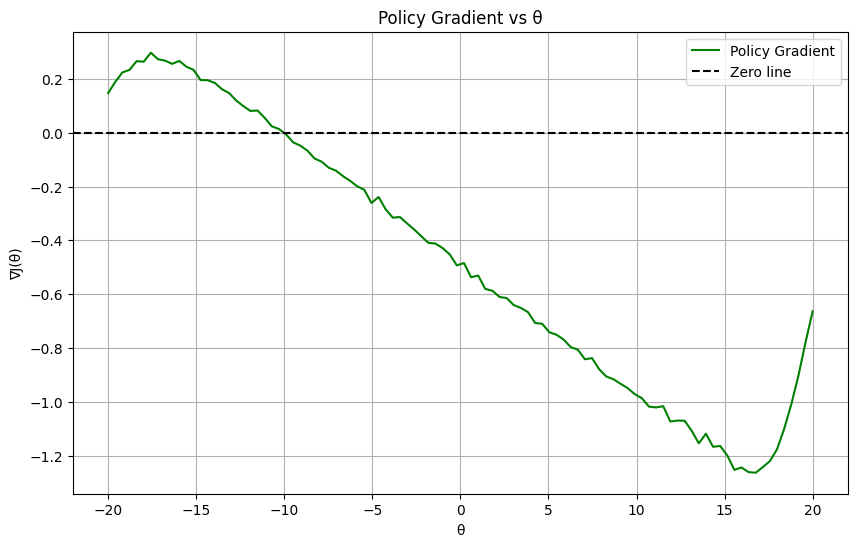

Zero crossing of policy gradient (approximate optimal θ): -10.30


In [6]:
def log_policy_gradient(state, action, theta, beta=0.5):
    """Calculate gradient of log policy for a given state-action pair."""
    prob_right = sigmoid(state - theta, beta)
    
    if action == 'R':
        # ∂/∂θ log π(R|s) = -β(1 - π(R|s))
        return -beta * (1 - prob_right)
    else:  # action == 'L'
        # ∂/∂θ log π(L|s) = β * π(R|s)
        return beta * prob_right

def simulate_episode_with_gradient(start_state, theta, L=20):
    """Simulate episode and collect state-action-reward information."""
    state = start_state
    states = [state]
    actions = []
    rewards = []
    log_gradients = []
    
    while -L <= state <= L:
        action = get_action(state, theta)
        log_grad = log_policy_gradient(state, action, theta)
        
        actions.append(action)
        log_gradients.append(log_grad)
        
        if action == 'R':
            state += 1
            if state > L:
                rewards.append(20)
                break
            else:
                rewards.append(-1)
        else:
            state -= 1
            if state < -L:
                rewards.append(0)
                break
            else:
                rewards.append(-1)
                
        states.append(state)
    
    return states[:-1], actions, rewards, log_gradients

def estimate_policy_gradient(theta, L=20, n_episodes=100000):
    """Estimate policy gradient using Monte Carlo rollouts."""
    total_gradient = 0
    start_states = np.random.randint(-L, L + 1, n_episodes)
    
    for start_state in start_states:
        states, actions, rewards, log_gradients = simulate_episode_with_gradient(start_state, theta, L)

        cumulative_rewards = []
        cum_reward = 0
        for r in reversed(rewards):
            cum_reward += r
            cumulative_rewards.insert(0, cum_reward)
            
        episode_gradient = sum([r * g for r, g in zip(cumulative_rewards, log_gradients)])
        total_gradient += episode_gradient
    
    return total_gradient / n_episodes

# Calculate policy gradients for different theta values
policy_gradients = []
print("Calculating policy gradients...")
for theta in tqdm(theta_range):
    grad = estimate_policy_gradient(theta, L=L)
    policy_gradients.append(grad)

plt.figure(figsize=(10, 6))
plt.plot(theta_range, policy_gradients, 'g-', label='Policy Gradient')
plt.axhline(y=0, color='k', linestyle='--', label='Zero line')
plt.xlabel('θ')
plt.ylabel('∇J(θ)')
plt.title('Policy Gradient vs θ')
plt.grid(True)
plt.legend()
plt.show()

zero_crossings_pg = np.where(np.diff(np.signbit(policy_gradients)))[0]
if len(zero_crossings_pg) > 0:
    zero_crossing_idx_pg = zero_crossings_pg[0]
    zero_crossing_theta_pg = theta_range[zero_crossing_idx_pg]
    print(f"Zero crossing of policy gradient (approximate optimal θ): {zero_crossing_theta_pg:.2f}")

### Question 4:  

4. Pick a starting value for θ = θ0 (e.g. θ0 = 0) and perform a relatively small number of
roll-outs τ under policy πθ to estimate vπθ (s) for all states

Estimating value function: 100%|██████████| 1000/1000 [00:00<00:00, 47603.58it/s]


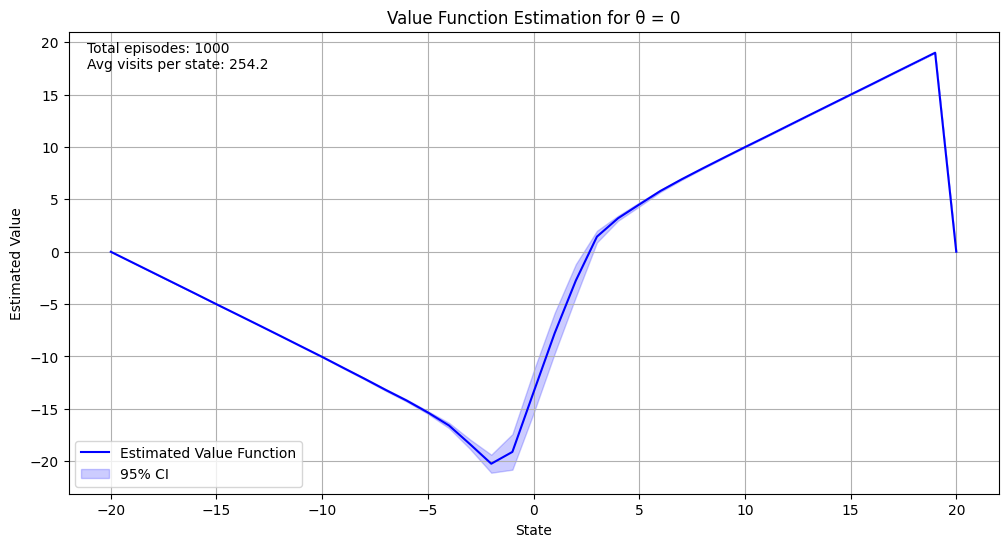

Average value across all states: -0.87
States with highest value: [(19, np.float64(19.0)), (18, np.float64(18.0)), (17, np.float64(17.0)), (16, np.float64(15.990588235294117)), (15, np.float64(14.995037220843672))]
States with lowest value: [(-2, np.float64(-20.236220472440944)), (-1, np.float64(-19.10810810810811)), (-3, np.float64(-18.37984496124031)), (-4, np.float64(-16.585365853658537)), (-5, np.float64(-15.342465753424657))]


In [7]:
def simulate_episode_for_value(start_state, theta, L=20):
    """
    Simulate an episode and return the states visited and corresponding returns.
    """
    state = start_state
    states = [state]
    rewards = []

    while -L <= state <= L:
        action = get_action(state, theta)
        if action == 'R':
            state += 1
            if state > L:  # Reached right terminal
                rewards.append(20)
                break
            else:
                rewards.append(-1)
        else:  # action == 'L'
            state -= 1
            if state < -L:  # Reached left terminal
                rewards.append(0)
                break
            else:
                rewards.append(-1)
        states.append(state)

    # Calculate returns for each state
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + G  # γ = 1 (no discounting)
        returns.insert(0, G)

    return states[:-1], returns  # Exclude last state as it's terminal

def estimate_value_function(theta0, L=20, n_episodes=1000):
    """
    Estimate the value function for all states using Monte Carlo rollouts.
    """
    # Initialize storage for returns for each state
    state_returns = {s: [] for s in range(-L, L+1)}

    # Perform rollouts
    for _ in tqdm(range(n_episodes), desc="Estimating value function"):
        start_state = np.random.randint(-L, L+1)
        states, returns = simulate_episode_for_value(start_state, theta0)

        # Store returns for each state visited
        for state, ret in zip(states, returns):
            state_returns[state].append(ret)

    # Calculate average return (value) for each state
    v = {}
    v_std = {}  # Also calculate standard deviation for confidence bounds
    for state in range(-L, L+1):
        if state_returns[state]:  # If state was visited
            v[state] = np.mean(state_returns[state])
            v_std[state] = np.std(state_returns[state]) / np.sqrt(len(state_returns[state]))
        else:
            v[state] = 0
            v_std[state] = 0

    return v, v_std, state_returns


L = 20
theta0 = 0
n_episodes = 1000

# Estimate value function
v, v_std, state_returns = estimate_value_function(theta0, L=L, n_episodes=n_episodes)

# Plotting
plt.figure(figsize=(12, 6))

# Plot value function
states = sorted(v.keys())
values = [v[s] for s in states]
errors = [v_std[s] for s in states]

plt.plot(states, values, 'b-', label='Estimated Value Function')
plt.fill_between(states, 
                 np.array(values) - 1.96 * np.array(errors),
                 np.array(values) + 1.96 * np.array(errors),
                 alpha=0.2, color='b', label='95% CI')

plt.xlabel('State')
plt.ylabel('Estimated Value')
plt.title(f'Value Function Estimation for θ = {theta0}')
plt.grid(True)
plt.legend()

# Add visit count information
visit_counts = {s: len(state_returns[s]) for s in states}
plt.text(0.02, 0.98, 
         f'Total episodes: {n_episodes}\nAvg visits per state: {np.mean(list(visit_counts.values())):.1f}',
         transform=plt.gca().transAxes, 
         verticalalignment='top')

plt.show()

# Print some statistics
print(f"Average value across all states: {np.mean(list(v.values())):.2f}")
print(f"States with highest value: {sorted(v.items(), key=lambda x: x[1], reverse=True)[:5]}")
print(f"States with lowest value: {sorted(v.items(), key=lambda x: x[1])[:5]}")


### Question 5:  

Once you have reasonable estimates for the value functions, use eq.6 to estimate the gra-
dient. Do this by averaging over many paths τ . Use the rolled-out paths to continue the updating of the critic.


Training A2C...


100%|██████████| 200/200 [16:14<00:00,  4.87s/it]


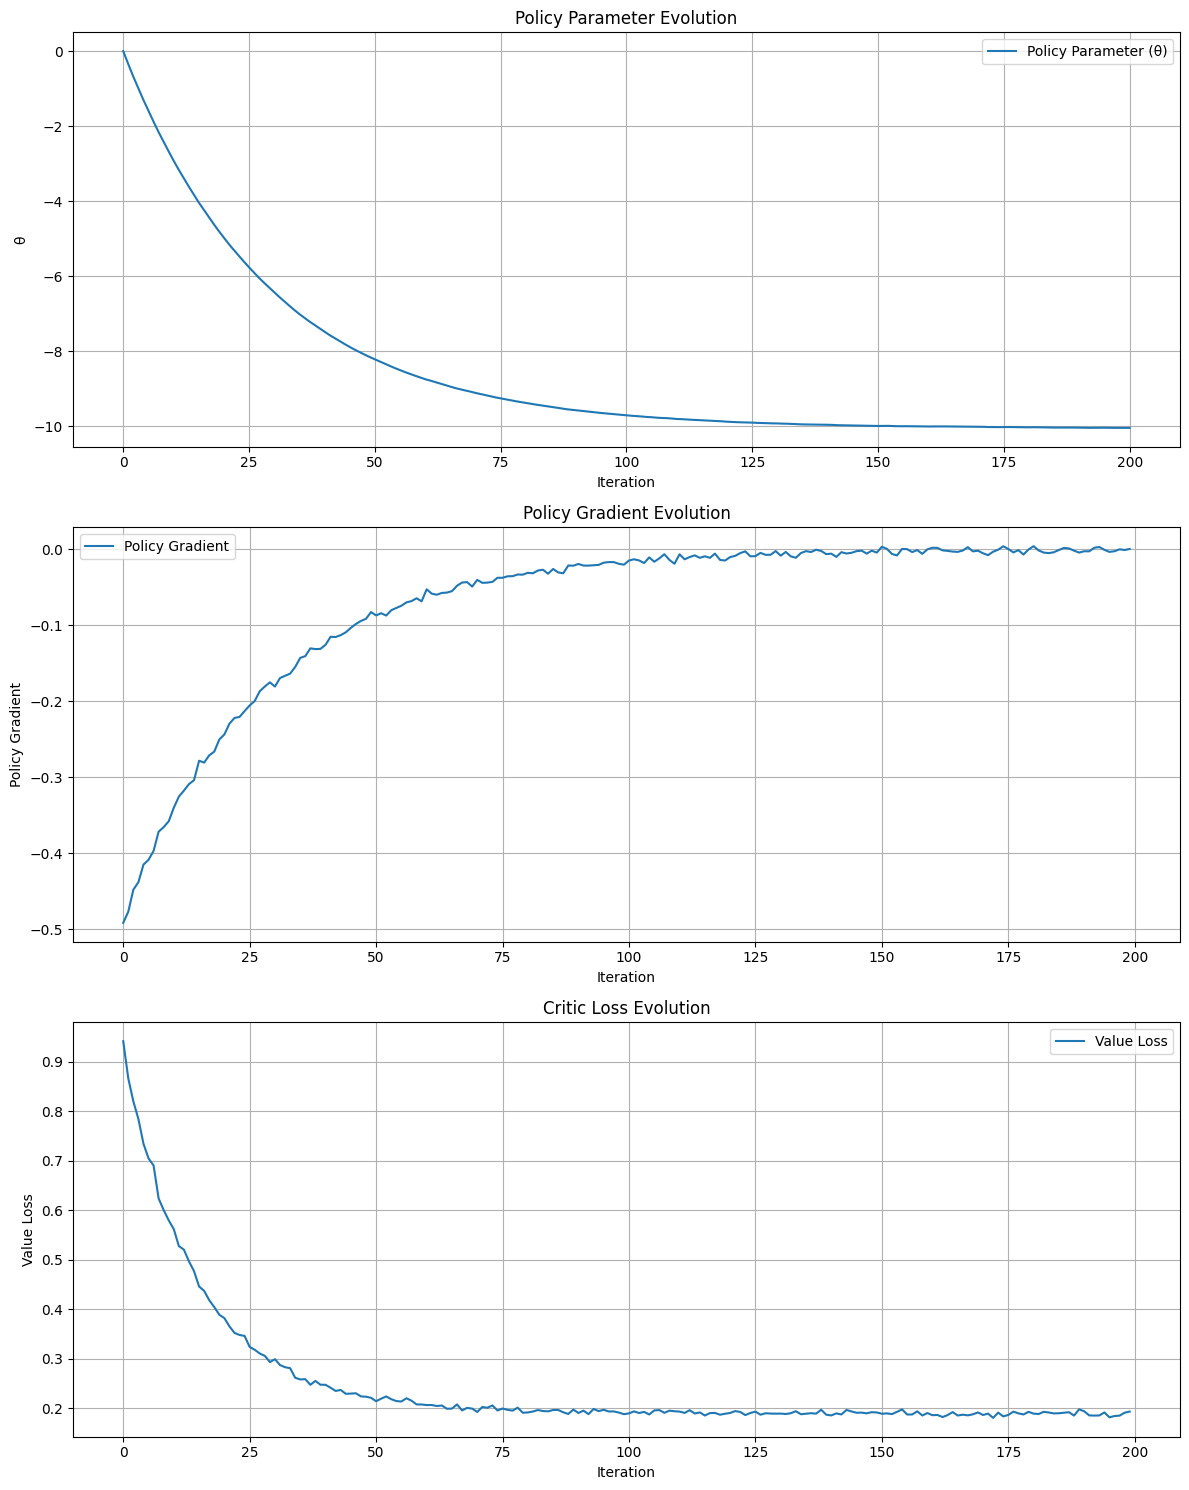

Final theta: -10.05
Final gradient: 0.00
Final value loss: 0.19


In [8]:
def compute_advantage(state, action, next_state, reward, v_function, gamma=1.0):
    """
    Compute advantage A(s,a) = Q(s,a) - V(s)
    where Q(s,a) ≈ r + γV(s')
    """
    q_sa = reward + gamma * v_function.get(next_state, 0)
    advantage = q_sa - v_function[state]
    return advantage

def update_value_function(v_function, state, target, alpha=0.01):
    """
    Update value function using TD learning
    V(s) = V(s) + α(target - V(s))
    """
    v_function[state] = v_function[state] + alpha * (target - v_function[state])

def simulate_episode_a2c(start_state, theta, v_function, L=20):
    """
    Simulate episode and collect information for A2C updates
    """
    state = start_state
    trajectory = []

    while -L <= state <= L:
        action = get_action(state, theta)
        old_state = state

        if action == 'R':
            state += 1
            reward = 20 if state > L else -1
            done = state > L
        else:
            state -= 1
            reward = 0 if state < -L else -1
            done = state < -L

        # Store transition
        trajectory.append({
            'state': old_state,
            'action': action,
            'next_state': state,
            'reward': reward,
            'log_grad': log_policy_gradient(old_state, action, theta),
            'done': done
        })

        if done:
            break

    return trajectory

def estimate_policy_gradient_a2c(theta, v_function, L=20, n_episodes=100000):
    """
    Estimate policy gradient using A2C
    """
    total_gradient = 0
    value_losses = []

    for _ in range(n_episodes):
        start_state = np.random.randint(-L, L+1)
        trajectory = simulate_episode_a2c(start_state, theta, v_function)

        episode_gradient = 0

        for t in trajectory:
            # Compute advantage
            advantage = compute_advantage(
                t['state'],
                t['action'],
                t['next_state'],
                t['reward'],
                v_function
            )

            episode_gradient += t['log_grad'] * advantage

            target = t['reward'] + (0 if t['done'] else v_function.get(t['next_state'], 0))
            old_value = v_function[t['state']]
            update_value_function(v_function, t['state'], target)
            value_losses.append((target - old_value)**2)

        total_gradient += episode_gradient

    return total_gradient / n_episodes, np.mean(value_losses)


def plot_training_results(thetas, gradients, value_losses):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))

    # Plot theta evolution
    ax1.plot(thetas, label='Policy Parameter (θ)')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('θ')
    ax1.set_title('Policy Parameter Evolution')
    ax1.grid(True)
    ax1.legend()

    # Plot gradients
    ax2.plot(gradients, label='Policy Gradient')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Policy Gradient')
    ax2.set_title('Policy Gradient Evolution')
    ax2.grid(True)
    ax2.legend()

    # Plot value loss
    ax3.plot(value_losses, label='Value Loss')
    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('Value Loss')
    ax3.set_title('Critic Loss Evolution')
    ax3.grid(True)
    ax3.legend()

    plt.tight_layout()
    plt.show()




# Suggested parameters
learning_rate = 0.7
n_episodes_per_iteration = 100000
n_iterations = 200
theta = 0
L = 20

# Initialize value function with estimates from Q4
v_function = v

thetas = [theta]
gradients = []
value_losses = []

print("Training A2C...")

for i in tqdm(range(n_iterations)):
    gradient, v_loss = estimate_policy_gradient_a2c(
        theta,
        v_function,
        L=L,
        n_episodes=n_episodes_per_iteration
    )

    theta += learning_rate * gradient

    # Store metrics
    thetas.append(theta)
    gradients.append(gradient)
    value_losses.append(v_loss)

# Plot results
plot_training_results(thetas, gradients, value_losses)





print(f"Final theta: {theta:.2f}")
print(f"Final gradient: {gradients[-1]:.2f}")
print(f"Final value loss: {value_losses[-1]:.2f}")


### Question 6:  

Use the gradient to update θ and repeat. Does A2C converge to the optimal value found
in question 1?

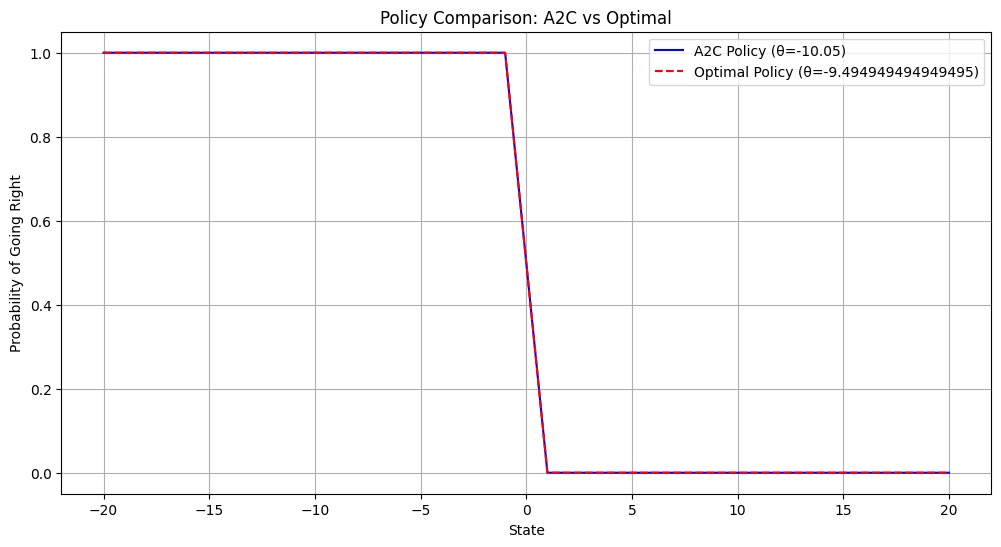


Convergence Analysis:
Parameter difference: 0.55
Relative parameter difference: 5.83%


In [ ]:
def get_action(state, theta):
    """Get action using softmax policy"""
    logits = np.array([theta * state, 0]) 
    exp_logits = np.exp(logits - np.max(logits))
    probs = exp_logits / exp_logits.sum()
    return 'R' if np.random.random() < probs[0] else 'L'

def estimate_value(theta, n_episodes=10000):
    """Estimate average return for a given policy parameter"""
    total_return = 0
    L = 20

    for _ in range(n_episodes):
        state = np.random.randint(-L, L+1)
        episode_return = 0
        done = False

        while not done and -L <= state <= L:
            action = get_action(state, theta)

            if action == 'R':
                next_state = state + 1
                reward = 20 if next_state > L else -1
                done = next_state > L
            else:
                next_state = state - 1
                reward = 0 if next_state < -L else -1
                done = next_state < -L

            episode_return += reward
            state = next_state

            if done:
                break

        total_return += episode_return

    return total_return / n_episodes

def compare_policies(theta_a2c, theta_optimal):
    """Compare A2C policy with optimal policy"""
    states = np.arange(-20, 21)

    def softmax_policy(s, theta):
        logits = np.array([theta * s, 0])
        exp_logits = np.exp(logits - np.max(logits))
        return exp_logits / exp_logits.sum()

    prob_right_a2c = [softmax_policy(s, theta_a2c)[0] for s in states]
    prob_right_optimal = [softmax_policy(s, theta_optimal)[0] for s in states]

    plt.figure(figsize=(12, 6))
    plt.plot(states, prob_right_a2c, 'b-', label=f'A2C Policy (θ={theta_a2c:.2f})')
    plt.plot(states, prob_right_optimal, 'r--', label=f'Optimal Policy (θ={theta_optimal})')
    plt.xlabel('State')
    plt.ylabel('Probability of Going Right')
    plt.title('Policy Comparison: A2C vs Optimal')
    plt.grid(True)
    plt.legend()
    plt.show()

# Parameters from previous results
theta_a2c = theta  
theta_optimal = optimal_theta  

compare_policies(theta_a2c, theta_optimal)

# Print final analysis
print("\nConvergence Analysis:")
print(f"Parameter difference: {abs(theta_a2c - theta_optimal):.2f}")
print(f"Relative parameter difference: {abs(theta_a2c - theta_optimal)/abs(theta_optimal)*100:.2f}%")